Problem: 

- Some of the images when loaded on the dashboard are from the product's behind with informations

- I would prefer to have the picture from the front

Solution:

- Develop a model that would classify if the image is in the correct way or not

Needs: 

- Download some images 

- Classify them

In [12]:
import pandas as pd
import copy
import os
import requests
import concurrent.futures
import queue

def get_image(code, number = 1):
    # Transform the code to produce the Open Food Facts image URL
    # number = the image we choose to retrieve
    if len(code) <= 8:
        url = f'https://images.openfoodfacts.org/images/products/{code}/{number}.jpg'
        return url
    elif len(code) > 8:
        code = "0"*(13 - len(code)) + code
        url = f'https://images.openfoodfacts.org/images/products/{code[:3]}/{code[3:6]}/{code[6:9]}/{code[9:]}/{number}.jpg'
        return url
    else:
        return None

def check_url_image(url):
    """
    Check if the link of the image is correct
    Return none if not
    """
    
    try:
        response = requests.head(url) # We use head instead of get, we only need to check the link
        response.raise_for_status()  # Raise an HTTPError for bad responses (4xx or 5xx)
        return url
    except requests.exceptions.RequestException:
        return None

def check_image_urls_parallel(urls):
    """
    The check_image_urls_parallel function uses concurrent.futures.ThreadPoolExecutor 
    to perform the checks concurrently.
    """
    
    with concurrent.futures.ThreadPoolExecutor() as executor:
        #The map function is used to apply the check_url function to each URL in parallel.
        results = executor.map(check_url_image, urls) # return a generator
        
    #The check_url_image function puts the results appropriate queue (checked_queue or failed_queue)
    for result in results:
        if result is not None:
            checked_queue.put(result)
        else:
            failed_queue.put(result)   
        
# Store globally informations on the url images.
# If one user check one image, it will be beneficial to all
# failed_img contains the url that failed.
checked_images = set()
failed_img = set()

# We set a queue for allowing a multi user environment 
checked_queue = queue.Queue()
failed_queue = queue.Queue()

def testing_img(images):
    to_test = []

    for i, url in enumerate(images):
        if url in checked_images:
            if url in failed_img:
                images[i] = None
        else: 
            if url is not None and 'http' in str(url): 
                checked_images.add(url)
                to_test.append(url)

    check_image_urls_parallel(to_test)
    
    # The queue helps us handle a multi users environement
    while not checked_queue.empty():
        url = checked_queue.get()
        checked_images.add(url)

    while not failed_queue.empty():
        url = failed_queue.get()
        failed_img.add(url)

    for i, url in enumerate(images):
        if url in failed_img:
            images[i] = None
      
    return images
        

try:
    # Get the current directory of the notebook
    file_dir = os.getcwd()
    app_dir = os.path.dirname(file_dir)

    # Define the path to the file in the /files directory
    #file_path = os.path.join(app_dir, 'files', 'cleaned_data.csv')
    file_path='cleaned_data.csv'
    # Now you can use the file_path to access your file
    with open(file_path, 'r') as file:
        data = pd.read_csv(file_path, sep = "\t", usecols=["code", "pnns_groups_2"])

except:
    # Get the directory of the script
    script_dir = os.path.dirname(os.path.abspath(__file__))

    # Go up one level to the parent directory (assuming the script is in the 'app' directory)
    app_dir = os.path.dirname(script_dir)

    # Define the path to the file in the /files directory
    file_path = os.path.join(app_dir, 'files', 'cleaned_data.csv')

    # Now you can use the file_path to access your file
    with open(file_path, 'r') as file:
        data = pd.read_csv(file_path, sep = "\t", usecols=["code", "pnns_groups_2"])

/var/folders/2f/rfnwlqbn4kn5mss8s54qbyhh0000gn/T/ipykernel_37554/1025803898.py:101: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path, sep = "\t", usecols=["code", "pnns_groups_2"])


In [13]:
# We selected only the needed informations
# Code, to find the url
# pnns_groups_2, to have different kind of products
data

,code,pnns_groups_2
0,1281,Pizza pies and quiches
1,1885,Fruits
2,5470,Bread
3,43595,Fruits
4,5016,Dressings and sauces
...,...,...
389307,5060640420083,Appetizers
389308,5060640420090,Appetizers
389309,5060640810136,unknown
389310,5060649650023,Fats


In [27]:
# We will generate the urls
# If we want to have the needed images, we will retrieve the 1 and next pictures for each
# We will take the 400 px format

for i in range(1, 4):
    data[f"image_{i}"] = data.apply(lambda x: get_image(str(x["code"]), number = f"{i}.400"), axis = 1)

In [81]:
import random

def download_images(image_urls, save_folder, number = 10):
    
    # Create a sample of the original list
    if number * 4 < len(image_urls):
        sampled_list = random.sample(image_urls, number * 4)
    
        os.makedirs(save_folder, exist_ok=True)

        i = 0
        row = 0
        number_failed = 0
        len_files = len(os.listdir(save_folder))

        # We check for the len, to not have a problem with the while
        if len(sampled_list) > number:
            while (i < number) & (row < len(sampled_list)):
                url = sampled_list[row]
                try:
                    response = requests.get(url)
                    response.raise_for_status()

                    # Extract the filename from the URL
                    filename = os.path.join(save_folder, f"image_{len_files + i}.jpg")

                    # Save the image to the specified folder
                    with open(filename, 'wb') as f:
                        f.write(response.content)

                    i += 1
                    row += 1

                except requests.exceptions.RequestException as e:
                    row += 1
                    number_failed += 1
            print(f"Failed loading for {number_failed} images")

        else: 
            print("Need more images")
    
    else:
        print(f"Number requested is too high, there are {len(image_urls)} images and more than {number * 4} were requested")

In [79]:
# Get a list of all files in the folder
files = os.listdir(folder)

We can create the different sub folder

In [278]:
# Create the main 'images' folder
folder = 'images/train/front'
os.makedirs(folder, exist_ok=True)

for pnns2 in data.pnns_groups_2.unique():
    print("Pnns 2: ", pnns2)
    mask = data[data["pnns_groups_2"] == pnns2]
    download_images(list(mask["image_1"]), folder, 5)

Pnns 2:  Pizza pies and quiches
Failed loading for 3 images
Pnns 2:  Fruits
Failed loading for 6 images
Pnns 2:  Bread
Failed loading for 8 images
Pnns 2:  Dressings and sauces
Failed loading for 1 images
Pnns 2:  Salty and fatty products
Failed loading for 2 images
Pnns 2:  Sweetened beverages
Failed loading for 5 images
Pnns 2:  Sweets
Failed loading for 12 images
Pnns 2:  unknown
Failed loading for 12 images
Pnns 2:  Biscuits and cakes
Failed loading for 8 images
Pnns 2:  Pastries
Failed loading for 0 images
Pnns 2:  Fish and seafood
Failed loading for 8 images
Pnns 2:  One-dish meals
Failed loading for 4 images
Pnns 2:  Appetizers
Failed loading for 0 images
Pnns 2:  Cheese
Failed loading for 17 images
Pnns 2:  Fats
Failed loading for 7 images
Pnns 2:  Processed meat
Failed loading for 3 images
Pnns 2:  Sandwiches
Failed loading for 6 images
Pnns 2:  Vegetables
Failed loading for 5 images
Pnns 2:  Breakfast cereals
Failed loading for 1 images
Pnns 2:  Chocolate products
Failed load

In [280]:
# Create the main 'images' folder
folder = 'images/test/front'
os.makedirs(folder, exist_ok=True)

for pnns2 in data.pnns_groups_2.unique():
    print("Pnns 2: ", pnns2)
    mask = data[data["pnns_groups_2"] == pnns2]
    download_images(list(mask["image_1"]), folder, 2)

Pnns 2:  Pizza pies and quiches
Failed loading for 3 images
Pnns 2:  Fruits
Failed loading for 1 images
Pnns 2:  Bread
Failed loading for 0 images
Pnns 2:  Dressings and sauces
Failed loading for 2 images
Pnns 2:  Salty and fatty products
Failed loading for 0 images
Pnns 2:  Sweetened beverages
Failed loading for 0 images
Pnns 2:  Sweets
Failed loading for 4 images
Pnns 2:  unknown
Failed loading for 5 images
Pnns 2:  Biscuits and cakes
Failed loading for 1 images
Pnns 2:  Pastries
Failed loading for 0 images
Pnns 2:  Fish and seafood
Failed loading for 1 images
Pnns 2:  One-dish meals
Failed loading for 2 images
Pnns 2:  Appetizers
Failed loading for 0 images
Pnns 2:  Cheese
Failed loading for 4 images
Pnns 2:  Fats
Failed loading for 3 images
Pnns 2:  Processed meat
Failed loading for 0 images
Pnns 2:  Sandwiches
Failed loading for 0 images
Pnns 2:  Vegetables
Failed loading for 0 images
Pnns 2:  Breakfast cereals
Failed loading for 0 images
Pnns 2:  Chocolate products
Failed loading

In [282]:
# Create the main 'images' folder
folder = 'images/validation/front'
os.makedirs(folder, exist_ok=True)

for pnns2 in data.pnns_groups_2.unique():
    print("Pnns 2: ", pnns2)
    mask = data[data["pnns_groups_2"] == pnns2]
    download_images(list(mask["image_1"]), folder, 2)

Pnns 2:  Pizza pies and quiches
Failed loading for 2 images
Pnns 2:  Fruits
Failed loading for 1 images
Pnns 2:  Bread
Failed loading for 3 images
Pnns 2:  Dressings and sauces
Failed loading for 2 images
Pnns 2:  Salty and fatty products
Failed loading for 0 images
Pnns 2:  Sweetened beverages
Failed loading for 0 images
Pnns 2:  Sweets
Failed loading for 2 images
Pnns 2:  unknown
Failed loading for 8 images
Pnns 2:  Biscuits and cakes
Failed loading for 2 images
Pnns 2:  Pastries
Failed loading for 1 images
Pnns 2:  Fish and seafood
Failed loading for 3 images
Pnns 2:  One-dish meals
Failed loading for 1 images
Pnns 2:  Appetizers
Failed loading for 1 images
Pnns 2:  Cheese
Failed loading for 7 images
Pnns 2:  Fats
Failed loading for 0 images
Pnns 2:  Processed meat
Failed loading for 0 images
Pnns 2:  Sandwiches
Failed loading for 2 images
Pnns 2:  Vegetables
Failed loading for 2 images
Pnns 2:  Breakfast cereals
Failed loading for 0 images
Pnns 2:  Chocolate products
Failed loading

In [285]:
# Create the main 'images' folder
folder = 'images/train/back'
os.makedirs(folder, exist_ok=True)

for pnns2 in data.pnns_groups_2.unique():
    print("Pnns 2: ", pnns2)
    mask = data[data["pnns_groups_2"] == pnns2]
    download_images(list(mask["image_2"]), folder, 3)
    download_images(list(mask["image_2"]), folder, 2)

Pnns 2:  Pizza pies and quiches
Failed loading for 4 images
Failed loading for 2 images
Pnns 2:  Fruits
Failed loading for 2 images
Failed loading for 1 images
Pnns 2:  Bread
Failed loading for 2 images
Failed loading for 0 images
Pnns 2:  Dressings and sauces
Failed loading for 1 images
Failed loading for 0 images
Pnns 2:  Salty and fatty products
Failed loading for 0 images
Failed loading for 0 images
Pnns 2:  Sweetened beverages
Failed loading for 0 images
Failed loading for 1 images
Pnns 2:  Sweets
Failed loading for 5 images
Failed loading for 5 images
Pnns 2:  unknown
Failed loading for 9 images
Failed loading for 7 images
Pnns 2:  Biscuits and cakes
Failed loading for 6 images
Failed loading for 4 images
Pnns 2:  Pastries
Failed loading for 0 images
Failed loading for 0 images
Pnns 2:  Fish and seafood
Failed loading for 2 images
Failed loading for 2 images
Pnns 2:  One-dish meals
Failed loading for 2 images
Failed loading for 2 images
Pnns 2:  Appetizers
Failed loading for 0 im

In [85]:
# Create the main 'images' folder
folder = 'images/test/back'
os.makedirs(folder, exist_ok=True)

for pnns2 in data.pnns_groups_2.unique():
    print("Pnns 2: ", pnns2)
    mask = data[data["pnns_groups_2"] == pnns2]
    download_images(list(mask["image_2"]), folder, 1)
    download_images(list(mask["image_3"]), folder, 1)

Pnns 2:  Pizza pies and quiches
Failed loading for 1 images
Failed loading for 4 images
Pnns 2:  Fruits
Failed loading for 1 images
Failed loading for 1 images
Pnns 2:  Bread
Failed loading for 2 images
Failed loading for 3 images
Pnns 2:  Dressings and sauces
Failed loading for 2 images
Failed loading for 4 images
Pnns 2:  Salty and fatty products
Failed loading for 0 images
Failed loading for 0 images
Pnns 2:  Sweetened beverages
Failed loading for 0 images
Failed loading for 0 images
Pnns 2:  Sweets
Failed loading for 0 images
Failed loading for 0 images
Pnns 2:  unknown
Failed loading for 2 images
Failed loading for 1 images
Pnns 2:  Biscuits and cakes
Failed loading for 0 images
Failed loading for 0 images
Pnns 2:  Pastries
Failed loading for 0 images
Failed loading for 4 images
Pnns 2:  Fish and seafood
Failed loading for 0 images
Failed loading for 0 images
Pnns 2:  One-dish meals
Failed loading for 2 images
Failed loading for 2 images
Pnns 2:  Appetizers
Failed loading for 0 im

In [281]:
# Create the main 'images' folder
folder = 'images/validation/back'
os.makedirs(folder, exist_ok=True)

for pnns2 in data.pnns_groups_2.unique():
    print("Pnns 2: ", pnns2)
    mask = data[data["pnns_groups_2"] == pnns2]
    download_images(list(mask["image_2"]), folder, 1)
    download_images(list(mask["image_3"]), folder, 1)

Pnns 2:  Pizza pies and quiches
Failed loading for 0 images
Failed loading for 1 images
Pnns 2:  Fruits
Failed loading for 0 images
Failed loading for 3 images
Pnns 2:  Bread
Failed loading for 0 images
Failed loading for 0 images
Pnns 2:  Dressings and sauces
Failed loading for 0 images
Failed loading for 4 images
Pnns 2:  Salty and fatty products
Failed loading for 0 images
Failed loading for 0 images
Pnns 2:  Sweetened beverages
Failed loading for 1 images
Failed loading for 0 images
Pnns 2:  Sweets
Failed loading for 0 images
Failed loading for 0 images
Pnns 2:  unknown
Failed loading for 0 images
Failed loading for 3 images
Pnns 2:  Biscuits and cakes
Failed loading for 0 images
Failed loading for 0 images
Pnns 2:  Pastries
Failed loading for 0 images
Failed loading for 0 images
Pnns 2:  Fish and seafood
Failed loading for 0 images
Failed loading for 1 images
Pnns 2:  One-dish meals
Failed loading for 1 images
Failed loading for 4 images
Pnns 2:  Appetizers
Failed loading for 0 im

In [222]:
def rename_files(path):
    # List all files in the current working directory
    files = os.listdir(path)
    files = [file for file in files if file.endswith(".jpg")]

    # Sort the files to ensure they are processed in order
    files.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))
    i = 0

    for file in files:
        os.rename(path + file, f"{path}image_{i}.jpg")
        i+= 1

We can delete bad images, rename then add as much as we want.

In [341]:
for file in ['train/front/', 'train/back/', 'test/front/', 'test/back/', 'validation/front/', 'validation/back/']:
    print(file, len(os.listdir('images/'+file)))
    rename_files('images/'+file)

train/front/ 307
train/back/ 353
test/front/ 206
test/back/ 58
validation/front/ 131
validation/back/ 97


For a first try, we have a good number of pictures

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications.xception import Xception

import time
import numpy as np
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

from plot_keras_history import show_history, plot_history
#from tensorflow.keras.preprocessing.image import load_img, img_to_array
#from tensorflow.keras.utils import to_categorical
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from keras import optimizers
from plot_keras_history import show_history, plot_history

In [98]:
def create_model_fct():
    """
    Return a Xception model trained on imagenet
    """
    
    model_base = Xception(include_top=False, weights="imagenet", input_shape=(299, 299, 3))
    preprocess_input = tf.keras.applications.xception.preprocess_input

    # We keep the weights of the model trained on imagenet
    for layer in model_base.layers:
        layer.trainable = False

    x = model_base.output
    # We add the last layers
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    # We want to predict 2 classes
    predictions = Dense(2, activation='softmax')(x)

    # We define the model
    model = Model(inputs=model_base.input, outputs=predictions)
    
    # We compile it
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])
    #alternative : adam
    
    print(model.summary())
    
    return model, preprocess_input

In [356]:
# We create the model
with tf.device('/gpu:0'): 
    model, preprocess_input = create_model_fct()


# Callback
# We follow the loss
# We stop training if the model has not improve after x step (patience)
# We register the model after each improvement

model_save_path = "./model_best_weights.h5"
checkpoint = ModelCheckpoint(model_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
callbacks_list = [checkpoint, es]

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 149, 149, 32)         864       ['input_7[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 149, 149, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 149, 149, 32)         0         ['block1_conv1_bn[0][0]'

 ormalization)                                                                                    
                                                                                                  
 block4_sepconv2_act (Activ  (None, 37, 37, 728)          0         ['block4_sepconv1_bn[0][0]']  
 ation)                                                                                           
                                                                                                  
 block4_sepconv2 (Separable  (None, 37, 37, 728)          536536    ['block4_sepconv2_act[0][0]'] 
 Conv2D)                                                                                          
                                                                                                  
 block4_sepconv2_bn (BatchN  (None, 37, 37, 728)          2912      ['block4_sepconv2[0][0]']     
 ormalization)                                                                                    
          

 ation)                                                                                           
                                                                                                  
 block7_sepconv1 (Separable  (None, 19, 19, 728)          536536    ['block7_sepconv1_act[0][0]'] 
 Conv2D)                                                                                          
                                                                                                  
 block7_sepconv1_bn (BatchN  (None, 19, 19, 728)          2912      ['block7_sepconv1[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block7_sepconv2_act (Activ  (None, 19, 19, 728)          0         ['block7_sepconv1_bn[0][0]']  
 ation)                                                                                           
          

 block9_sepconv3_bn (BatchN  (None, 19, 19, 728)          2912      ['block9_sepconv3[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 add_79 (Add)                (None, 19, 19, 728)          0         ['block9_sepconv3_bn[0][0]',  
                                                                     'add_78[0][0]']              
                                                                                                  
 block10_sepconv1_act (Acti  (None, 19, 19, 728)          0         ['add_79[0][0]']              
 vation)                                                                                          
                                                                                                  
 block10_sepconv1 (Separabl  (None, 19, 19, 728)          536536    ['block10_sepconv1_act[0][0]']
 eConv2D) 

                                                                                                  
 block12_sepconv3_act (Acti  (None, 19, 19, 728)          0         ['block12_sepconv2_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 block12_sepconv3 (Separabl  (None, 19, 19, 728)          536536    ['block12_sepconv3_act[0][0]']
 eConv2D)                                                                                         
                                                                                                  
 block12_sepconv3_bn (Batch  (None, 19, 19, 728)          2912      ['block12_sepconv3[0][0]']    
 Normalization)                                                                                   
                                                                                                  
 add_82 (A

In [355]:
def dataset_fct(path, preprocess, image_size = (299,299), validation_split=0, batch_size = 32, data_type=None):
    dataset = tf.keras.utils.image_dataset_from_directory(
        path, 
        labels='inferred', #Subfolder where separated, so the labels are inferred
        label_mode='categorical',
        class_names=["back", "front"],  # 0 = back, 1 = front
        batch_size=32, 
        image_size=(image_size),
        shuffle=True, 
        seed=42, 
        validation_split=validation_split, 
        subset=data_type
    )
    if preprocess:
        # On applique le pré processing avant de retourner les images
        dataset = dataset.map(lambda x, y: (preprocess(x), y))
    
    return dataset

In [373]:
# We prepare the files
dataset_train = dataset_fct("images/train", preprocess_input, validation_split=0, data_type=None)
dataset_test = dataset_fct("images/test", preprocess_input, validation_split=0, data_type=None)
dataset_val = dataset_fct("images/validation", preprocess_input, validation_split=0, data_type=None)

Found 658 files belonging to 2 classes.
Found 262 files belonging to 2 classes.
Found 226 files belonging to 2 classes.


In [374]:
# Optimization of dataset

AUTOTUNE = tf.data.experimental.AUTOTUNE

dataset_train = dataset_train.cache().prefetch(buffer_size=AUTOTUNE)
dataset_val = dataset_val.cache().prefetch(buffer_size=AUTOTUNE)
dataset_test = dataset_test.cache().prefetch(buffer_size=AUTOTUNE)

Now we can train the model

In [359]:
time1 = time.time()

with tf.device('/gpu:0'): 
    history = model.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=32, epochs=50, callbacks=callbacks_list, verbose=1)

elapsed_time = time.time() - time1

Epoch 1/50
21/21 [==============================] - ETA: 0s - loss: 0.3625 - accuracy: 0.8267
Epoch 1: val_loss improved from inf to 0.24978, saving model to ./model_best_weights.h5


/Users/ruben/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


21/21 [==============================] - 70s 3s/step - loss: 0.3625 - accuracy: 0.8267 - val_loss: 0.2498 - val_accuracy: 0.9071
Epoch 2/50
21/21 [==============================] - ETA: 0s - loss: 0.1448 - accuracy: 0.9438
Epoch 2: val_loss improved from 0.24978 to 0.20981, saving model to ./model_best_weights.h5


2023-12-08 13:58:44.789625: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


21/21 [==============================] - 64s 3s/step - loss: 0.1448 - accuracy: 0.9438 - val_loss: 0.2098 - val_accuracy: 0.9425
Epoch 3/50
21/21 [==============================] - ETA: 0s - loss: 0.0970 - accuracy: 0.9590
Epoch 3: val_loss did not improve from 0.20981
21/21 [==============================] - 64s 3s/step - loss: 0.0970 - accuracy: 0.9590 - val_loss: 0.2201 - val_accuracy: 0.9469
Epoch 4/50
21/21 [==============================] - ETA: 0s - loss: 0.0774 - accuracy: 0.9666
Epoch 4: val_loss did not improve from 0.20981
21/21 [==============================] - 68s 3s/step - loss: 0.0774 - accuracy: 0.9666 - val_loss: 0.2376 - val_accuracy: 0.9425
Epoch 5/50
21/21 [==============================] - ETA: 0s - loss: 0.0577 - accuracy: 0.9787
Epoch 5: val_loss did not improve from 0.20981
21/21 [==============================] - 65s 3s/step - loss: 0.0577 - accuracy: 0.9787 - val_loss: 0.2648 - val_accuracy: 0.9381
Epoch 6/50
21/21 [==============================] - ETA: 0s -

In [360]:
# Let's see the results

model.load_weights(model_save_path)

loss, accuracy_train = model.evaluate(dataset_train, verbose=True)
print("Accuracy on the train dataset: {:.2f}%".format(accuracy_train*100))

loss, accuracy_val = model.evaluate(dataset_val, verbose=False)
print("Accuracy on the validation dataset: {:.2f}%".format(accuracy_val*100))

loss, accuracy_test = model.evaluate(dataset_test, verbose=False)
print("Accuracy on the test dataset:  {:.2f}%".format(accuracy_test*100))

21/21 [==============================] - 53s 3s/step - loss: 0.0883 - accuracy: 0.9635
Accuracy on the train dataset: 96.35%
Accuracy on the validation dataset: 94.25%
Accuracy on the test dataset:  97.71%


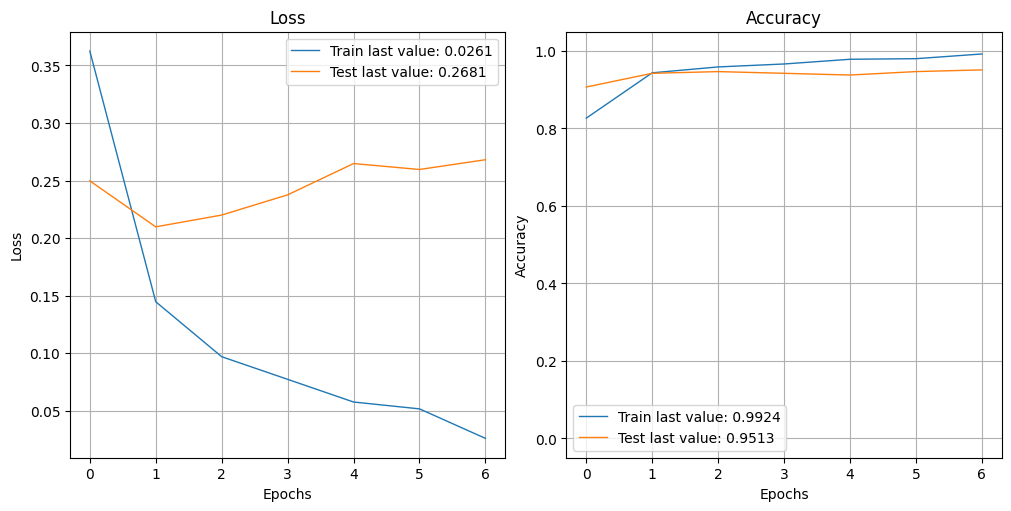

In [361]:
# The graphic
show_history(history)

In [425]:
# Fonctions permettant de récupérer les labels 

def extract_labels(x, y):
    return y

# Ils sont retournés encodés numpy, donc on utilise np.argmax pour retourner encodé
def extract_all_labels(df) : 
    real_labels = df.map(extract_labels)
    real_labels = np.concatenate([labels.numpy() for labels in real_labels])
    real_labels = np.argmax(real_labels, axis = 1)
    
    return real_labels

# Fonction affichant la matrice de confusion
def matrice_confusion(real_labels, predicted_labels):
    
    conf_mat = metrics.confusion_matrix(real_labels, predicted_labels)
    
    df_cm = pd.DataFrame(conf_mat, index = ['Back', 'Front'],
                      columns = ['Back', 'Front'])
    plt.figure(figsize = (6,4))
    
    sns.heatmap(df_cm, annot=True, cmap="Blues")

# Fonction affichant plusieurs métriques comparant les résultats de prédictions vs réels et matrice de confusion
def results_prediction(predicted_labels, real_labels):
    
    print(metrics.classification_report(real_labels, predicted_labels))
    
    # on appel la fonction matrice_confusion
    matrice_confusion(real_labels, predicted_labels)


              precision    recall  f1-score   support

           0       0.91      0.98      0.95        53
           1       1.00      0.98      0.99       209

    accuracy                           0.98       262
   macro avg       0.95      0.98      0.97       262
weighted avg       0.98      0.98      0.98       262



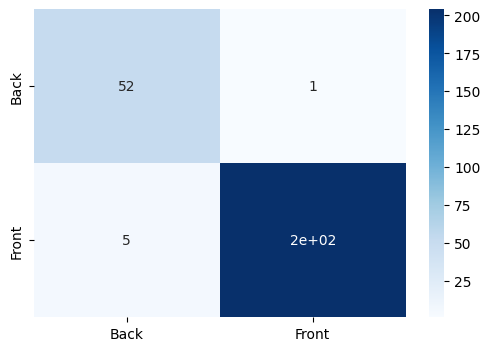

In [404]:
real_test_label = extract_all_labels(dataset_test)
predict_test = model.predict(dataset_test)
predict_test_label = np.argmax(predict_test, axis = 1)
results_prediction(real_test_label, predict_test_label)

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       332
           1       0.99      0.93      0.96       326

    accuracy                           0.96       658
   macro avg       0.97      0.96      0.96       658
weighted avg       0.97      0.96      0.96       658



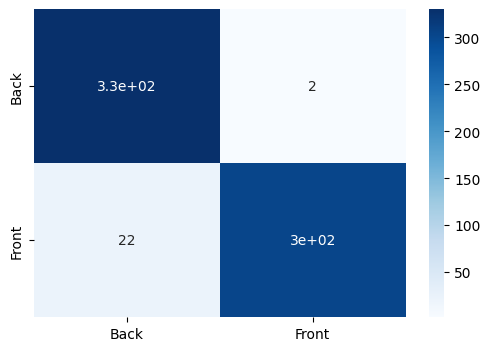

In [405]:
real_train_label = extract_all_labels(dataset_train)
predict_train = model.predict(dataset_train)
predict_train_label = np.argmax(predict_train, axis = 1)
results_prediction(real_train_label, predict_train_label)

              precision    recall  f1-score   support

           0       0.91      0.96      0.93        91
           1       0.97      0.93      0.95       135

    accuracy                           0.94       226
   macro avg       0.94      0.94      0.94       226
weighted avg       0.94      0.94      0.94       226



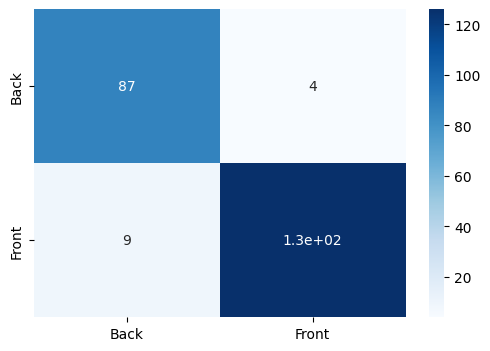

In [408]:
real_val_label = extract_all_labels(dataset_val)
predict_val = model.predict(dataset_val)
predict_val_label = np.argmax(predict_val, axis = 1)
results_prediction(real_val_label, predict_val_label)

In [366]:
# Fonction permettant d'afficher des images précises dans les batchs

def show_selected_img(dataset, batch_index = 2, image_index_within_batch = 3, Rescale = True):

    for i, (batch_images, batch_labels) in enumerate(dataset):
        if i == batch_index:

            image = batch_images[image_index_within_batch]
            label = batch_labels[image_index_within_batch]
            plt.figure(figsize=(5, 5))

            # On rescale l'image pour l'affichage
            rescaled_image = tf.image.convert_image_dtype(image, dtype=tf.uint8)
            plt.imshow(rescaled_image)

            plt.axis("off")
            plt.show()

image : 45 batch : 1 batch_image : 13
Bonne prédiction : Front
Fausse prédiction : Back 
Pourcentage de probabilité : 99 %


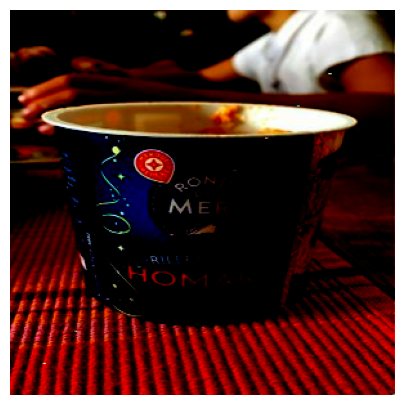

image : 56 batch : 1 batch_image : 24
Bonne prédiction : Back
Fausse prédiction : Front 
Pourcentage de probabilité : 75 %


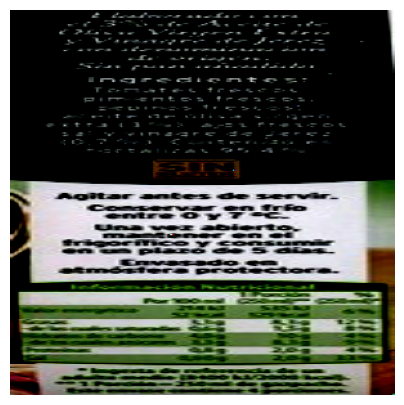

image : 83 batch : 2 batch_image : 19
Bonne prédiction : Back
Fausse prédiction : Front 
Pourcentage de probabilité : 54 %


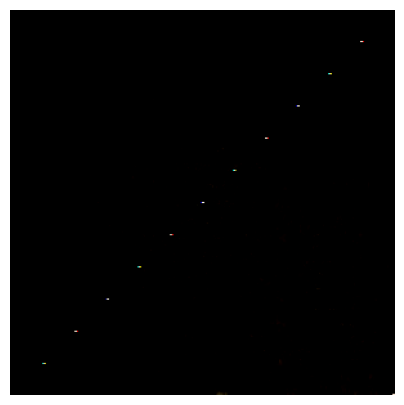

image : 141 batch : 4 batch_image : 13
Bonne prédiction : Back
Fausse prédiction : Front 
Pourcentage de probabilité : 96 %


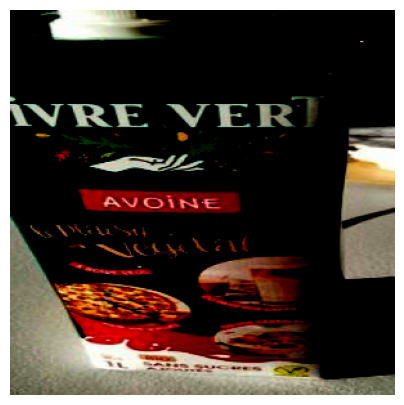

image : 194 batch : 6 batch_image : 2
Bonne prédiction : Back
Fausse prédiction : Front 
Pourcentage de probabilité : 54 %


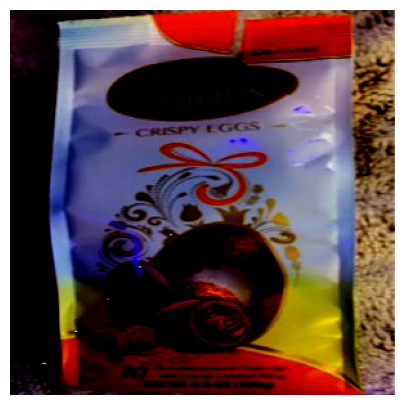

image : 197 batch : 6 batch_image : 5
Bonne prédiction : Back
Fausse prédiction : Front 
Pourcentage de probabilité : 95 %


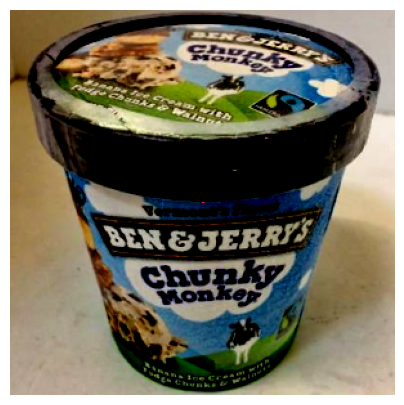

In [402]:
# On récupère les pourcentages de probabilité pour le label
probabilite_pourcentage = np.max(predict_test, axis=1)

prediction = {1:'Front', 0:'Back'}

# On parcours et on compare les résultats de label entre prédits et vrais labels
for i in range(len(real_test_label)):
  # Si ça ne correspond pas, on affiche l'image
  if real_test_label[i] != predict_test_label[i]:
    # On recherche le batch et l'image
    batch = int(np.floor(i/32))
    batch_image = i - (32 * batch)

    print("image :", i, "batch :", batch, "batch_image :", batch_image)

    print("Bonne prédiction :", prediction[real_test_label[i]])
    print("Fausse prédiction : %s " %prediction[predict_test_label[i]])
    print("Pourcentage de probabilité : %d %%" %(probabilite_pourcentage[i] * 100))

    show_selected_img(dataset_test, batch, batch_image)

In [411]:
import pickle

In [412]:
def save_model(model, preprocess_input, model_save_path):
    model.save(model_save_path)
    with open("preprocess_input.pkl", "wb") as f:
        pickle.dump(preprocess_input, f)

# Save the model
save_model(model, preprocess_input, model_save_path)


In [413]:
## To reload model

def load_model(model_save_path):
    model = tf.keras.models.load_model(model_save_path)
    with open("preprocess_input.pkl", "rb") as f:
        preprocess_input = pickle.load(f)
    return model, preprocess_input

# Load the model in another project
loaded_model, loaded_preprocess_input = load_model(model_save_path)


8/8 [==============================] - 15s 2s/step
              precision    recall  f1-score   support

           0       0.91      0.96      0.93        91
           1       0.97      0.93      0.95       135

    accuracy                           0.94       226
   macro avg       0.94      0.94      0.94       226
weighted avg       0.94      0.94      0.94       226



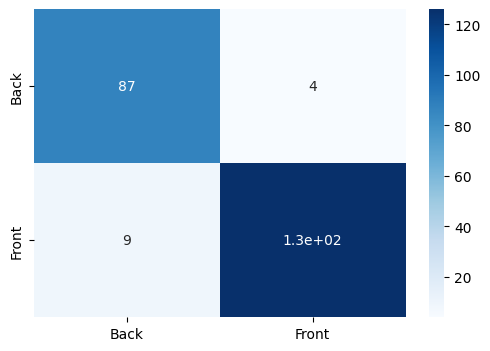

In [427]:
real_val_label = extract_all_labels(dataset_val)
t = loaded_model.predict(dataset_val)
tt = np.argmax(t, axis = 1)
results_prediction(real_val_label, tt)

In [419]:
real_val_label

array([0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0])